In [1]:
# Python

# Hypothesis Testing


In this notebook we demonstrate formal hypothesis testing using the NHANES data.

It is important to note that the NHANES data are a "complex survey". The data are not an independent and representative sample from the target population. Proper analysis of complex survey data should make use of additional information about how the data were collected. Since complex survey analysis is a somewhat specialized topic, we ignore this aspect of the data here, and analyze the NHANES data as if it were an independent and identically distributed sample from a population.

First we import the libraries that we will need.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import scipy.stats.distributions as dist

## Data importation

Below we read the data, and convert some of the integer codes to text values. The NHANES codebooks for `SMQ020`, `RIAGENDR`, and `DMDCITZN` describe the meanings of the numerical codes.

In [3]:
da = pd.read_csv('nhanes_2015_2016.csv')

In [4]:
da.head()

,SEQN,ALQ101,ALQ110,ALQ130,SMQ020,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,...,BPXSY2,BPXDI2,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,HIQ210
0,83732,1.0,NaN,1.0,1,1,62,3,1.0,5.0,...,124.0,64.0,94.8,184.5,27.8,43.3,43.6,35.9,101.1,2.0
1,83733,1.0,NaN,6.0,1,1,53,3,2.0,3.0,...,140.0,88.0,90.4,171.4,30.8,38.0,40.0,33.2,107.9,NaN
2,83734,1.0,NaN,NaN,1,1,78,3,1.0,3.0,...,132.0,44.0,83.4,170.1,28.8,35.6,37.0,31.0,116.5,2.0
3,83735,2.0,1.0,1.0,2,2,56,3,1.0,5.0,...,134.0,68.0,109.8,160.9,42.4,38.5,37.7,38.3,110.1,2.0
4,83736,2.0,1.0,1.0,2,2,42,4,1.0,4.0,...,114.0,54.0,55.2,164.9,20.3,37.4,36.0,27.2,80.4,2.0


In [5]:
da.nunique()

SEQN        5735
ALQ101         3
ALQ110         4
ALQ130        15
SMQ020         4
RIAGENDR       2
RIDAGEYR      63
RIDRETH1       5
DMDCITZN       4
DMDEDUC2       6
DMDMARTL       7
DMDHHSIZ       7
WTINT2YR    4355
SDMVPSU        2
SDMVSTRA      15
INDFMPIR     440
BPXSY1        68
BPXDI1        50
BPXSY2        67
BPXDI2        49
BMXWT        997
BMXHT        509
BMXBMI       393
BMXLEG       218
BMXARML      163
BMXARMC      297
BMXWAIST     794
HIQ210         3
dtype: int64

In [6]:
# Convert some columns :
da["RIAGENDR"] = da["RIAGENDR"].replace({1:"Male", 2:"Female"})
da["SMQ020"] = da["SMQ020"].replace({1:"Yes", 2:"No", 7:np.nan, 9:np.nan })
da["DMDCITZN"] = da["DMDCITZN"].replace({1:"Yes", 2:"No", 7:np.nan, 9:np.nan})

In [7]:
da["SMQ020"].unique()

array(['Yes', 'No', nan], dtype=object)

##  1) Hypothesis Tests for one Proportion

The most basic hypothesis test may be the :


$$
Z = \frac{\hat{p} - p}{SE} \quad \text{where} \quad SE = \sqrt{p(1-p)/n} \quad \text{and} \quad \hat{p} = \frac{x}{n}
$$

where :

* $SE$ : is the standard error of the estimate.
* $\hat{p}$ : is the best estimate
* $p$ : is the hypothesized estimate

* **one-sample test for a proportion**. This test is used if we have specified a particular value as the null value for the proportion, and we wish to assess if the data are compatible with the true parameter value being equal to this specified value. One-sample tests are not used very often in practice, because it is **not very common** that we have a specific fixed value to use for comparison.

For illustration, imagine that the rate of lifetime smoking in another country was known to be 40% ($p$), and we wished to assess whether the rate of lifetime smoking in the US were different from 40%. In the following notebook cell, we carry out the **(two-sided) one-sample test** that the population proportion of smokers is 0.4, and obtain a p-value of 0.43. This indicates that the NHANES data are compatible with the proportion of (ever) smokers in the US being 40%.

### <ins> **Method 1 :**</ins>

First of all, we need to calculate $\hat{p}$ :

In [20]:
x = da.SMQ020.dropna() == "Yes"
phat = x.mean()
phat                  # best estimate

0.4050655021834061

In [21]:
p = .4                    # hypothesized estimate
n = len(x)                # nb of "success"
se = np.sqrt(p*(1-p)/n)    # standard error

test_stat = (phat-p) / se

In [22]:
# two-sided one-sample test
pvalue = 2 * dist.norm.cdf(-np.abs(test_stat))       # P(|Z|<test_stat)
print(test_stat, pvalue)

0.7823563854332805 0.4340051581348052


### <ins> **Method 2 : statsmodels**</ins>

The following cell carries out the same test as performed above using the `Statsmodels` library. The results in the first (default) case below are slightly different from the results obtained above because Statsmodels by default uses the sample proportion ($\hat{p}$) instead of the null proportion ($p$) when computing the standard error. This distinction is rarely consequential, but we can specify that the null proportion should be used to calculate the standard error, and the results agree exactly with what we calculated above. The first two lines below carry out tests using the normal approximation to the sampling distribution of the test statistic, and the third line below carries uses the exact binomial sampling distribution. We can see here that the p-values are nearly identical in all three cases. This is expected when the sample size is large, and the proportion is not close to either 0 or 1.

In [23]:
# Twoside is the default mode in sm.stats.proportions_ztest: it prints test statistic, p-value
# By default : Normal approximation with estimated proportion (phat) in calculating SE
# since the values of x is either 0 or 1 : x.sum() will return the nb of smokers
print(sm.stats.proportions_ztest(count=x.sum(), nobs=len(x), value=p))

# Normal approximation with null proportion (p) in SE
print(sm.stats.proportions_ztest(count=x.sum(), nobs=len(x), value=p, prop_var=p))

# Binominal : prints the p-value
print(sm.stats.binom_test(count = x.sum(), nobs=len(x), prop = 0.4))

(0.7807518954896244, 0.43494843171868214)
(0.7823563854332805, 0.4340051581348052)
0.4340360854410028


## 2) Hypothesis Tests for two proportions

Comparative tests tend to be used **much more frequently** than tests comparing one population to a fixed value. 

$$
z = \frac{(\hat{p}_1 - \hat{p}_2) - (p_1 - p_2)}{\sqrt{\hat{p}(1-\hat{p})\left(\frac{1}{n_1} + \frac{1}{n_2}\right)}}= \frac{(\hat{p}_1 - \hat{p}_2) - (p_1 - p_2)}{SE}
$$

where $SE$ is the standard error, and the pooled proportion : 

$$
\hat{p} = \frac{n_1 \hat{p}_1 + n_2 \hat{p}_2}{n_1 + n_2} = \frac{X_1 + X_2}{n_1 + n_2}
$$

* **two-sample test of proportions :** is used to assess whether the proportion of individuals with some trait differs between two sub-populations.

For example, we can compare the smoking rates between females and males. Since smoking rates vary strongly with age, we do this in the subpopulation of **people between 20 and 25 years of age**. In the cell below, we carry out this test without using any libraries, implementing all the test procedures using Python code. We find that the **smoking rate for men is around 10 percentage points greater than the smoking rate for females**, and this difference is statistically significant (the p-value is around 0.01).

### <ins> **Method 1 :**</ins>

First we need to calculate $\hat{p}_1$ and $\hat{p}_2$

In [12]:
dx = da[["SMQ020", "RIAGENDR", "RIDAGEYR"]].dropna()
dx = dx.loc[(dx.RIDAGEYR >=20) & (dx.RIDAGEYR <=25),:]
dx.head()

,SMQ020,RIAGENDR,RIDAGEYR
6,Yes,Male,22
17,No,Female,24
26,Yes,Male,22
38,No,Female,20
40,Yes,Male,24


In [13]:
p = dx.groupby("RIAGENDR")["SMQ020"].agg([lambda z : np.mean(z=="Yes"), "size"])
p

,<lambda_0>,size
RIAGENDR,,
Female,0.238971,272
Male,0.341270,252


In [14]:
p.columns = ["Smoke", "N"]
p

,Smoke,N
RIAGENDR,,
Female,0.238971,272
Male,0.341270,252


In [15]:
phat_1 = p.Smoke[0] # Male
phat_2 = p.Smoke[1] # Female

print(f"Male : {phat_1}\nFemale: {phat_2}")

Male : 0.23897058823529413
Female: 0.3412698412698413


For the pooled proportion :

In [16]:
# pooled proportion 
phat = (dx.SMQ020 == "Yes").mean()
phat

0.2881679389312977

In [17]:
# variance:
va = phat * (1-phat)

# Standard deviation
n1 = p.N[1]  # nb of male smokers
n2 = p.N[0]  # nb of female smokers

se = np.sqrt(va * (1/n1 + 1/n2))
se

0.039599757248262944

In [18]:
# Calculate the test statistic and the p-value : p1-p2 =0 (NH : they are equal)
test_stat = (phat_1-phat_2)/se
pvalue = dist.norm.cdf(-np.abs(test_stat))   # pvalue = P(|Z|< test_stat)

print(test_stat, pvalue)

-2.5833303066279414 0.004892579528754187


### <ins> **Method 2 (statsmodels) :**</ins>
Essentially the same test as above can be conducted by converting the "Yes/No" responses into numbers ("Yes"=1, "No"=0) and conducting a two-sample t-test, as below :

In [19]:
dx_females = dx.loc[dx['RIAGENDR'] == "Female", "SMQ020"].replace({
    "Yes" : 1,
    "No" : 0
})

dx_males = dx.loc[dx['RIAGENDR'] == "Male", "SMQ020"].replace({
    "Yes" : 1,
    "No" :0
})

sm.stats.ttest_ind(x1=dx_females, x2=dx_males)

(-2.5949731446269344, 0.00972590232121254, 522.0)

## 3) Hypothesis tests comparing means

Tests of means are similar in many ways to tests of proportions. Just as with proportions, for comparing means there are **one** and **two-sample tests**, **z-tests** and **t-tests**, and **one-sided** and **two-sided** tests.

### 3-1) One Sample mean / One Sample test

$$ Z = \frac{\bar{X} - \mu}{\sigma/\sqrt{n}} \quad \text{and} \quad t = \frac{\bar{X} - \mu}{s/\sqrt{n}}$$

where :

* $\bar{X}$ is the sample mean
* $\mu$ is the hypothesized mean (NH)
* $\sigma$ is the population standard deviation
* $s$ is the sample standard deviation

As with tests of proportions, **one-sample tests of means are not very common**, but we illustrate a one sample test in the cell below. We compare systolic blood pressure `BPXSY1` to the fixed value 120 ($\mu$) (which is the lower threshold for "pre-hypertension"), and find that the mean is significantly different from 120 (the point estimate of the mean ($\bar{X}$) is 126).

In [33]:
dx = da[["BPXSY1", "RIDAGEYR", "RIAGENDR"]].dropna()

# The hypothesized mean under the NH
mu = 120

# Male between 40 and 50
dx = dx.loc[(dx["RIDAGEYR"]>=40) & (dx["RIDAGEYR"]<=50) & (dx["RIAGENDR"]=="Male"),:]

# sample mean
X_bar = dx["BPXSY1"].mean()
print(X_bar)

# test-statistic and p-value:
sm.stats.ztest(x1 = dx.BPXSY1, value=mu)

125.86698337292161


(7.469764137102597, 8.033869113167905e-14)

In [29]:
da.RIAGENDR

0         Male
1         Male
2         Male
3       Female
4       Female
         ...  
5730    Female
5731      Male
5732    Female
5733      Male
5734    Female
Name: RIAGENDR, Length: 5735, dtype: object

### 3-2) Two-Sample mean/ Two-Sample test

There are a number of different variants on the two-sample t-test. Two often-encountered variants are the t-test carried out using the t-distribution :

$$t = \frac{(\bar{X}_1 - \bar{X}_2) - (\mu_1 - \mu_2)}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}$$

and the t-test carried out using the normal approximation to the reference distribution of the test statistic, often called a z-test :

$$Z = \frac{(\bar{X}_1 - \bar{X}_2) - (\mu_1 - \mu_2)}{\sqrt{\frac{\sigma_1^2}{n_1} + \frac{\sigma_2^2}{n_2}}}$$


Where :

* $\mu_1, \mu_2$ : the hypothesized means (are equal in the NH)
* $\bar{X_1}, \bar{X_2}$ : the best estimates for the means 
* $s_1, s_2$ : Standard deviation of both groups
* $n_1, n_2$ : The size of both groups


In the cell below, we carry out a formal test of the null hypothesis that $\mu_1$ the mean blood pressure for women between the ages of 50 and 60 is equal to $\mu_2$ the mean blood pressure of men between the ages of 50 and 60 ($\mu_1 =\mu_2$). The results indicate that while the mean systolic blood pressure for men is slightly greater than that for women ($\bar{X}_2 = 129$ mm/Hg versus $\bar{X}_1 =128$ mm/Hg), **this difference is not statistically significant**. Below we display results from both these testing approaches. When the sample size is large, the difference between the t-test and z-test is very small.

In [81]:
dx

,BMXBMI,RIDAGEYR,RIAGENDR
0,27.8,62,Male
1,30.8,53,Male
2,28.8,78,Male
3,42.4,56,Female
4,20.3,42,Female
...,...,...,...
5730,21.5,76,Female
5731,33.8,26,Male
5732,31.0,80,Female
5733,26.0,35,Male


In [82]:
dx= da[["BPXSY1", "RIDAGEYR", "RIAGENDR"]].dropna()
dx = dx.loc[(dx["RIDAGEYR"]>=50) & (dx["RIDAGEYR"]<=60),:]

# Female blood pressure 
bp_female = dx.loc[dx["RIAGENDR"] == "Female", "BPXSY1"]

# Male blood pressure
bp_male = dx.loc[dx["RIAGENDR"] == "Male", "BPXSY1"]


### <ins> **Method 1 :**</ins>

In [83]:
# Best estimates of the means 
X_1 = bp_female.mean()   # Woman
X_2 = bp_male.mean()     # Men

# Standard deviations
sigma_1 = bp_female.std()  # Woman
sigma_2 = bp_male.std()     # Men

# the sizes 
n_1 = len(bp_female)
n_2 = len(bp_male)

In [84]:
print(X_1, X_2)

127.92561983471074 129.23829787234044


In [85]:
# test statistic 
test_stat = (X_1-X_2) / np.sqrt(sigma_1**2/n_1 +sigma_2**2/n_2)
pvalue = 2* dist.norm.cdf(-abs(test_stat))     # P(|Z|<test_stat)
print(f"Test statistic : {test_stat}\np-value : {pvalue}")

Test statistic : -1.105528804150671
p-value : 0.2689305203990454


### <ins> **Method 2 (statsmodels) :**</ins>


In [86]:
# prints test statistic, p-value
print(sm.stats.ztest(x1 = bp_female, x2=bp_male))

(-1.105435895556249, 0.2689707570859362)


In [87]:
# prints test statistic, p-value and degrees of freedom
print(sm.stats.ttest_ind(x1= bp_female, x2=bp_male))

(-1.105435895556249, 0.26925004137768577, 952.0)


Another important aspect of two-sample mean testing is

* **heteroscedasticity**: meaning that the variances within the two groups being compared may be different.

While the goal of the test is to compare the means, the variances play an important role in calibrating the statistics (deciding how big the mean difference needs to be to be declared statistically significant).

In the NHANES data, we see that there are moderate differences between the amount of variation in BMI `BMXBMI` for females and for males, looking **within 10-year age bands**. In every age band, females having greater variation than males.

In [88]:
da["RIDAGEYR"].describe()

count    5735.000000
mean       48.052310
std        18.431011
min        18.000000
25%        32.000000
50%        48.000000
75%        63.000000
max        80.000000
Name: RIDAGEYR, dtype: float64

In [89]:
dx = da[["BMXBMI", "RIDAGEYR", "RIAGENDR"]].dropna()
# create a column of age intervals
da["AGEGRP"] = pd.cut(x= da.RIDAGEYR, bins = [18, 30, 40,50,60,70,80])

In [90]:
da.groupby(["AGEGRP", "RIAGENDR"])["BMXBMI"].agg(np.std).unstack()

RIAGENDR,Female,Male
AGEGRP,,
"(18, 30]",7.745893,6.649440
"(30, 40]",8.315608,6.622412
"(40, 50]",8.076195,6.407076
"(50, 60]",7.575848,5.914373
"(60, 70]",7.604514,5.933307
"(70, 80]",6.284968,4.974855


The standard error of the mean difference (e.g. mean female blood pressure minus mean male blood pressure) can be estimated in at least two different ways. In the statsmodels library, these approaches are referred to as the **"pooled"** and the **"unequal"** approach to estimating the variance. If the variances are equal (i.e. there is no heteroscedasticity), then there should be little difference between the two approaches. Even in the presence of moderate heteroscedasticity, as we have here, we can see that the results for the two methods are quite similar.

Below we have a loop that considers each 10-year age band and assesses the evidence for a difference in mean BMI for women and for men. The results printed in each row of output are the test-statistic and p-value.

In [99]:
for k, v in da.groupby("AGEGRP"):
    # k are the keys (age intervals), v are the values (the dataframes)
    
    bmi_female = v.loc[v["RIAGENDR"]=="Female", "BMXBMI"].dropna()
    bmi_female = sm.stats.DescrStatsW(bmi_female)
    
    bmi_male = v.loc[v["RIAGENDR"]=="Male", "BMXBMI"].dropna()
    bmi_male = sm.stats.DescrStatsW(bmi_male)
    
    print(k)
    print("Pooled : ", sm.stats.CompareMeans(bmi_female, bmi_male).ztest_ind(usevar="pooled"))
    print("unequal : ", sm.stats.CompareMeans(bmi_female, bmi_male).ztest_ind(usevar="unequal"))
    
    print()

(18, 30]
Pooled :  (1.7026932933643388, 0.08862548061449649)
unequal :  (1.7174610823927268, 0.08589495934713022)

(30, 40]
Pooled :  (1.4378280405644916, 0.1504828511464818)
unequal :  (1.4437869620833494, 0.14879891057892475)

(40, 50]
Pooled :  (2.8933761158070186, 0.003811246059501354)
unequal :  (2.9678691663536725, 0.0029987194174035366)

(50, 60]
Pooled :  (3.362108779981367, 0.0007734964571391746)
unequal :  (3.375494390173923, 0.0007368319423226574)

(60, 70]
Pooled :  (3.6172401442432753, 0.000297761021031936)
unequal :  (3.62848309454456, 0.0002850914147149227)

(70, 80]
Pooled :  (2.926729252512258, 0.0034254694144858636)
unequal :  (2.937779886769224, 0.0033057163315192996)



## 4) Paired tests

A common situation in applied research is to measure the same quantity multiple times on each unit of analysis. For example, in NHANES, systolic blood pressure `BPXSY1` is measured at least two times (sometimes there is a third measurement) on each subject. Although the measurements are repeated, there is no guarantee that the mean is the same each time, i.e. the mean blood pressure may be slightly lower on the second `BPXSY2` measurement compared to the first `BPXSY1`, since people are a bit more nervous the first time they are measured.

* **Paired test :** is a modified form of mean test that can be used when we are comparing two repeated measurements on the same unit.

A paired t-test for means is equivalent to taking the difference between the first and second measurement, and using a one-sample test to compare the mean of these differences to zero.

Below we see that in the entire NHANES sample, the first measurement of systolic blood pressure is on average 0.67 mm/Hg greater than the second measurement. While this difference is not large, it is **strongly statistically significant**. That is, there is strong evidence that the mean values for the first and second blood pressure measurement differ.

In [104]:
# first and second measurement for blood pressure
dx = da[["BPXSY1", "BPXSY2"]].dropna()

# difference between the first and second measurement
db = dx.BPXSY1 - dx.BPXSY2

print(db.mean())
sm.stats.ztest(db)

0.6749860309182343


(9.800634425497911, 1.1188070930963587e-22)

To probe this effect further, we can divide the population into **10 year wide age bands and also stratify by gender**, then carry out the paired t-test within each of the resulting **12 strata**. We see that the second systolic blood pressure measurement `BPXSY2` is always lower on average than the first `BPXSY1`. The difference is larger for older people and for males. The difference is statistically significant for females over 30, and for males over 60.

Conducting many hypothesis tests and "cherry picking" the interesting results is usually a bad practice. Here we are doing such "multiple testing" for illustration, and acknowledge that the strongest differences may be over-stated. Nevertheless, there is a clear and consistent trend with age -- older people tend to have greater differences between their first and second blood pressure measurements than younger people. There is also a difference between the genders, with older men having a stronger difference between the first and second blood pressure measurements than older women. The gender difference for younger people is less clear.

In [108]:
dx = da[["RIAGENDR", "RIDAGEYR", "BPXSY1", "BPXSY2"]].dropna()

# age bins
dx["AGEGRP"] = pd.cut(dx["RIDAGEYR"], bins = [18,30,40,50,60,70,80])

# a look up table into BP for males and females (per bin)
dx.groupby(["AGEGRP", "RIAGENDR"])[["BPXSY1", "BPXSY2"]].agg(np.mean).unstack()

BPXSY1                  BPXSY2            
RIAGENDR      Female        Male      Female        Male
AGEGRP                                                  
(18, 30]  110.903339  118.535156  110.766257  118.531250
(30, 40]  114.267606  121.745370  113.596244  121.282407
(40, 50]  121.407249  126.263158  120.810235  126.084211
(50, 60]  128.310112  129.336449  127.541573  128.967290
(60, 70]  132.691919  133.854722  131.813131  132.581114
(70, 80]  140.697436  136.706806  139.246154  134.675393

In [110]:
for k, g in dx.groupby(["RIAGENDR","AGEGRP"]):
    # difference of bp
    db= g.BPXSY1 - g.BPXSY2
    
    # print stratum definition, mean difference, sample size, tst statistic, p-value
    print(k, db.mean(), sm.stats.ztest(db.values,value =0))

('Female', Interval(18, 30, closed='right')) 0.13708260105448156 (0.7612107360791227, 0.4465312067051751)
('Female', Interval(30, 40, closed='right')) 0.6713615023474179 (3.307398751951031, 0.0009416674523368051)
('Female', Interval(40, 50, closed='right')) 0.5970149253731343 (2.6040611621024654, 0.009212631487347644)
('Female', Interval(50, 60, closed='right')) 0.7685393258426966 (3.1023718750881724, 0.0019197663012041955)
('Female', Interval(60, 70, closed='right')) 0.8787878787878788 (3.1024528501809625, 0.0019192411825181255)
('Female', Interval(70, 80, closed='right')) 1.4512820512820512 (5.141706875154317, 2.7225365035529816e-07)
('Male', Interval(18, 30, closed='right')) 0.00390625 (0.01959622841647691, 0.9843654725443948)
('Male', Interval(30, 40, closed='right')) 0.46296296296296297 (1.9451535788714596, 0.05175649697939119)
('Male', Interval(40, 50, closed='right')) 0.17894736842105263 (0.7201800810138878, 0.47141412641258706)
('Male', Interval(50, 60, closed='right')) 0.36915

# Power and sample size for hypothesis tests

Like nearly any analysis with data, hypothesis tests will yield more sensitive and confident results when there are larger amounts of data. Here we will study the relationship between the sample size (amount of data), and the behavior of a hypothesis test. For illustration, we will use the paired t-test for assessing whether the first and second systolic blood pressure measurement `BPXSY1` and `BPXSY2` have different means, restricting to people between 50 and 60 years of age.

**The simulation below randomly subsamples sets of 100, 200, 400, and 800 people from the 50-60 year old subset of NHANES, and conducts a paired z-test on each subsample. This process is repeated 500 times for each sample size.**

We report the fraction of these 500 trials where the p-value was smaller than 0.05. A higher fraction of trials where $p<0.05$ implies that it is easier to detect a difference between the first and second blood pressure measurements. We see that this proportion (called **"statistical power"**) is only around 0.2 when the sample size is 100, and grows to essentially 100% when the sample size is 800. Note that all of these subsamples are drawn from the same parent population, so there is no change from subsample to subsample in terms of whether the means are truly different. The only thing that changes is our evidence that the difference is real. When the sample size is small, we rarely amass such evidence.

In [119]:
# a list of "np arrays that contain pvalues for each subpopulation"
all_p =[]

dy = dx.loc[(da["RIDAGEYR"]>=50) & (da["RIDAGEYR"]<=60),:]

# subsample of 100,200,400,800
for n in 100,200,400,800:
    # a list of pvalues for each subsample
    pv = []
    # conducting a paired z-test 500 times for each subsample of 100,200,400,800
    for i in range(500) :
        # sampling n times from the parent population dy
        dz = dy.sample(n)
        # differecnce between blood pressure
        db = dz.BPXSY1 - dz.BPXSY2
        # test statistic (we use _ because we don't need it) and pvalue for each subsample
        _, p = sm.stats.ztest(db.values, value=0)
        pv.append(p)
    
    # convert pv to numpy array
    pv = np.asarray(pv)
    
    # add the numpy array that conatins all the pvalue of the subsample to all_p
    all_p.append(pv)
    
    # The statistical power for each subsample : proportion of trials where p<0.05
    print(f"In the subsample of {n} people, the proportion of trials where p<0.05, is : {(pv<0.05).mean()}")

In the subsample of 100 people, the proportion of trials where p<0.05, is : 0.23
In the subsample of 200 people, the proportion of trials where p<0.05, is : 0.384
In the subsample of 400 people, the proportion of trials where p<0.05, is : 0.644
In the subsample of 800 people, the proportion of trials where p<0.05, is : 1.0


In [121]:
#print(all_p)

In [122]:
len(all_p)

4

In [125]:
len(all_p[0])

500

In the simulation code above, we saved all the p-values to the array named `all_p` so we can consider them further here. The histogram below shows the distribution of p-values for 500 subsamples of data of size 100. We see that there are more smaller p-values than larger ones, but not to a dramatic degree. Some of the p-values are almost 1, indicating that the subsample mean differences were almost zero in those cases.

<Axes: ylabel='Count'>

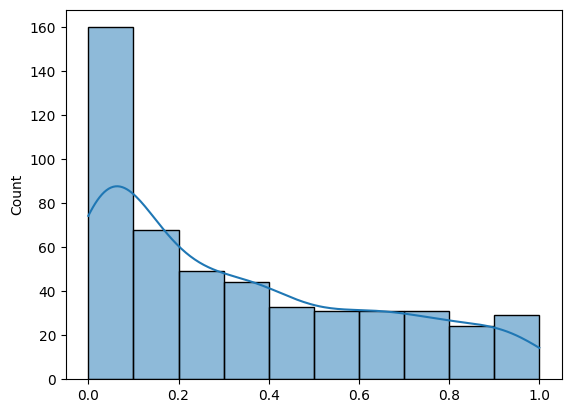

In [136]:
sns.histplot(all_p[0],kde = True)

Next we inspect the distribution of p-values for subsamples of size 400. We see that the p-values are much more concentrated close to zero compared to when we had only 100 data points. If we obtain a sample of size 400 from this population, we have around a 70% chance of obtaining a p-value smaller than 0.05, and are very unlikely to obtain a p-value greater than 0.4.

<Axes: ylabel='Count'>

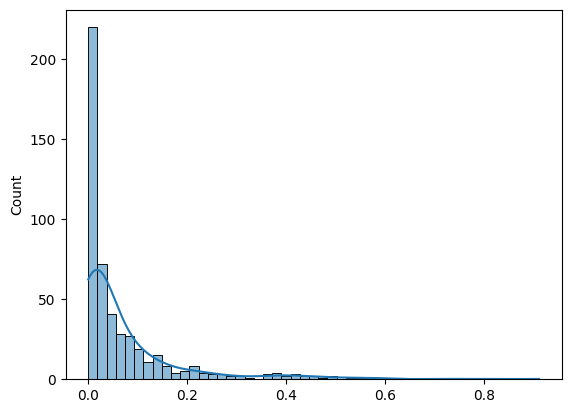

In [137]:
sns.histplot(all_p[2], kde=True)